In [1]:
# !pip install pandas nibabel nilearn matplotlib
import pandas as pd
import nibabel as nib
from nilearn import plotting
import numpy as np

dk = nib.load("aparc+aseg-mni_09c.nii.gz")
parc_info = pd.read_csv(
    "FreeSurferColorLUT.txt",
    sep="\s+",
    comment="#",
    header=None,
    names=["ID", "Label", "R", "G", "B", "A"],
)
tvbase_atlas = nib.load("tpl-MNI152NLin2009cAsym_parc-hcpmmp1_desc-ordered.nii.gz")
tvbase_atlas_info = pd.read_csv(
    "hcpmmp1_ordered.txt",
    sep="\s+",
    header=None,
    comment="#",
    names=["ID", "Label", "R", "G", "B", "A"],
)

adni_labels = np.loadtxt("/Users/leonmartin_bih/Downloads/roi_names.txt", dtype=str)

In [2]:
parc_info

,ID,Label,R,G,B,A
0,0,Unknown,0,0,0,0
1,1,Left-Cerebral-Exterior,70,130,180,0
2,2,Left-Cerebral-White-Matter,245,245,245,0
3,3,Left-Cerebral-Cortex,205,62,78,0
4,4,Left-Lateral-Ventricle,120,18,134,0
...,...,...,...,...,...,...
1373,14171,wm_rh_S_suborbital,21,20,60,0
1374,14172,wm_rh_S_subparietal,101,60,60,0
1375,14173,wm_rh_S_temporal_inf,21,180,180,0
1376,14174,wm_rh_S_temporal_sup,223,220,60,0


In [3]:
tvbase_atlas_info

,ID,Label,R,G,B,A
0,1,L_V1,63,5,255,255
1,2,L_MST,54,103,129,255
2,3,L_V6,62,78,178,255
3,4,L_V2,23,50,233,255
4,5,L_V3,15,40,226,255
...,...,...,...,...,...,...
374,375,R_Hippocampus,220,216,20,255
375,376,R_Amygdala,103,255,255,255
376,377,R_Accumbens,255,165,0,255
377,378,R_VentralDC,165,42,42,255


In [4]:
# Artificial data
data = {}
for l in adni_labels:
    data.update({l: np.random.rand()})

In [5]:
def data2volume(data, parcellation, parc_info=None):
    volume = np.zeros(parcellation.shape)
    parcellation_data = parcellation.get_fdata()
    for l, d in data.items():
        if isinstance(l, str) and parc_info is not None:
            roi_idx = parc_info[parc_info["Label"].str.lower() == l.lower()][
                "ID"
            ].item()
        else:
            roi_idx = l
        if not roi_idx in np.unique(parcellation_data):
            print(l, roi_idx)
        volume = np.where(parcellation_data == roi_idx, d, volume)

    return nib.Nifti1Image(volume, parcellation.affine)

In [6]:
volume_data = data2volume(data, dk, parc_info=parc_info)

In [7]:
from nilearn.maskers import NiftiLabelsMasker

masker = NiftiLabelsMasker(labels_img=tvbase_atlas)

parc_data = masker.fit_transform(volume_data)

In [8]:
# both possible
parc_data = {
    tvbase_atlas_info[tvbase_atlas_info.ID == i + 1].Label.item(): d
    for i, d in enumerate(parc_data[0, :])
}
volume_data_check = data2volume(parc_data, tvbase_atlas, parc_info=tvbase_atlas_info)


# parc_data = {i + 1: d for i, d in enumerate(parc_data[0, :])}
# volume_data_check = data2volume(parc_data, tvbase_atlas)

In [9]:
len(parc_data)

379

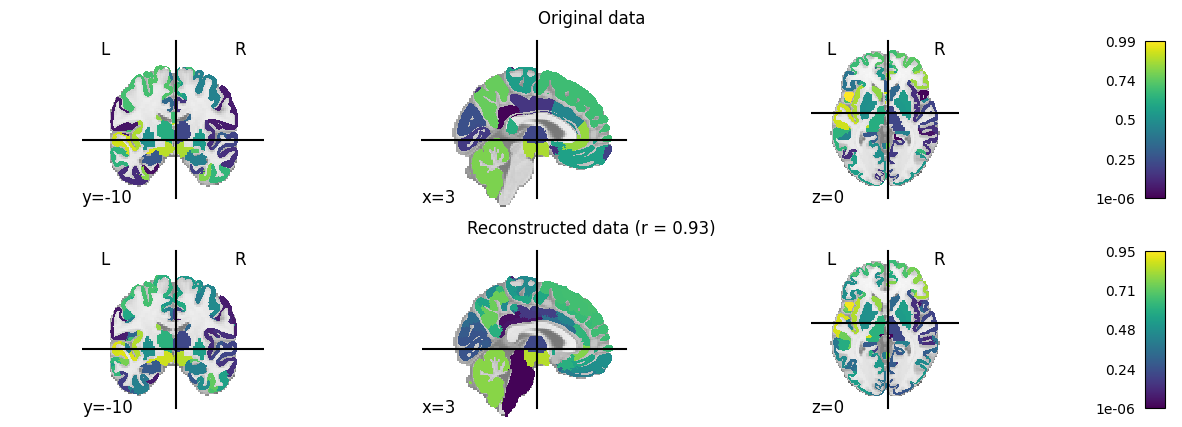

In [10]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(2, 1, figsize=(15, 5))

ax[0].set_title("Original data")
plotting.plot_stat_map(volume_data, cmap="viridis", axes=ax[0], cut_coords=(3, -10, 0))

ax[1].set_title(
    f"Reconstructed data (r = {np.corrcoef(volume_data.get_fdata().ravel(), volume_data_check.get_fdata().ravel())[0, 1]:.2f})"
)
plotting.plot_stat_map(
    volume_data_check, cmap="viridis", axes=ax[1], cut_coords=(3, -10, 0)
)